In [1]:
import numpy as np 
import xarray as xr 
import scipy 
import matplotlib.pyplot as plt  # Plotting library
import cartopy, cartopy.crs as ccrs  # Plot maps
import random 
import satcmaps as cmaps
import image_retrieval as img
import goesRequest2 as goes 
from recenterIR import recenter_ir

In [2]:
def calculate_degrees(dataset): # Adapted from https://www.star.nesdis.noaa.gov/atmospheric-composition-training/python_abi_lat_lon.php
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = dataset['x']  # E/W scanning angle in radians
    y_coordinate_1d = dataset['y']  # N/S elevation angle in radians
    projection_info = dataset['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height + projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')

    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

    x_coordinate_1d.close()
    y_coordinate_1d.close()
    projection_info.close()
    dataset.close()
    
    return abi_lat, abi_lon


In [3]:
def Gradient2D(arr, lats, lons):
    if lats.ndim == 2:
        lats = lats[:, 0]
    if lons.ndim == 2:
        lons = lons[0, :]

    dA_dlon, dA_dlat = np.gradient(arr, lats, lons, axis=(1,0))
    return dA_dlon, dA_dlat

In [4]:
def reproject(dataset, lats, lons, pos):   
    size = 3.6
    IR = dataset['CMI'].data - 273.15
                        
    # Extents and interpolation for IR
    minimglat = pos[0] - size
    maximglat = pos[0] + size
    minimglon = pos[1] - size
    maximglon = pos[1] + size
    res = 0.0179985     # degrees resolution at nadir
    grid = np.meshgrid(np.arange(minimglat, maximglat, res), np.arange(minimglon, maximglon, res))
    
    lats = lats.flatten()
    lons = lons.flatten()
    IR = IR.flatten()
    
    # Fix shape issue for boolean conditions
    floater_IR = (np.greater(lats, minimglat) & np.greater(maximglat, lats) &
                    np.greater(lons, minimglon) & np.greater(maximglon, lons) & np.isfinite(IR))

    gridded_data = scipy.interpolate.griddata((lats[floater_IR], lons[floater_IR]), IR[floater_IR], (grid[0], grid[1]), method='linear')
    
    dataset.close()

    return grid[1], grid[0], gridded_data

In [5]:
def rePoPolar(dataset, lats, lons, center = None):
    if center is None:
        clat = np.nanmean(lats)
        clon = np.nanmean(lons)
    else:
        clat, clon = center
    print(clat, clon)

    R = 6371.0
    cphi = np.cos(np.radians(clat))
    x = R * np.radians(lons - clon) * cphi
    y = R * np.radians(lats - clat)

    r = np.sqrt(x**2 + y**2)
    t = np.arctan2(y, x)

    rBins = np.linspace(0, 500, 500)
    tBins = np.linspace(np.nanmin(t), np.nanmax(t), 200)

    R, T = np.meshgrid(rBins, tBins)
    newX, newY = R * np.cos(T), R * np.sin(T)
    gridded_data = scipy.interpolate.griddata((x.flatten(), y.flatten()), dataset.flatten(), (newX.flatten(), newY.flatten()), method='nearest')

    polar = xr.Dataset(
        {
            'data': (('r', 'theta'), gridded_data.reshape(R.shape).transpose())
        },
        coords={
            'r': rBins,
            'theta': tBins
        }
    )

    polar = polar.sel(r = slice(0, 500))
    polar = polar.interp(r = np.arange(0, 500, 1))

    return x, y, polar['data']


In [6]:
def run(data, polar, xkm, ykm):
    from scipy.ndimage import gaussian_filter1d

    ir_std = np.nanstd(polar.values, axis = 1)
    ir_std = gaussian_filter1d(ir_std, sigma = 6)
    ir_azi = np.nanmax(polar.values, axis = 1)
    radii = polar.r.values

    diff = (np.diff(ir_std) / np.diff(radii))
    diff2_std = np.diff(diff) / np.diff(radii[1:])
    diff2 = np.diff(ir_azi) / np.diff(radii)
    diff2 = gaussian_filter1d(diff2, sigma = 2)

    min_ir_rad, min_ir_radARG = radii[np.nanargmin(ir_azi)], np.nanargmin(ir_azi)
    min_ir_temp = np.nanmin(ir_azi)
    eyerad, eyeradARG = radii[np.nanargmin(diff2[:np.nanargmin(ir_azi)])], np.nanargmin(diff2[:np.nanargmin(ir_azi)]) 
    eyetemp = np.nanmax(ir_azi[radii < min_ir_rad])
    icdoedge, icdoedgeARG = (eyerad + min_ir_rad) / 2, int((eyeradARG + min_ir_radARG) / 2)
    tempArray = np.arange(0, 499, dtype = 'float32')

    temp = int(min_ir_radARG)
    zeroPoint = temp + np.where((ir_azi[temp:] > -5) & (ir_azi[temp:] < 5))[0][0]
    print(zeroPoint)

    tempArray[0:temp] = np.nan
    tempArray[temp:] = diff[temp:]
    tempArray[zeroPoint:] = np.nan
    ocdoedge, ocdoedgeARG = radii[np.nanargmax(tempArray)], np.nanargmax(tempArray)

    # candidates = temp + np.where((diff2_std[temp:temp+100] > -0.001) & (diff2_std[temp:temp+100] < 0.001))[0]
    # candidates = np.append(candidates, ocdoedge)
    # print(candidates, np.nanmean(candidates), np.nanmedian(candidates))
    # ocdoedge, ocdoedgeARG = np.nanmax([radii[int(np.nanmean(candidates))], radii[int(np.nanmedian(candidates))]]), np.nanmax([int(np.nanmean(candidates)), int(np.nanmedian(candidates))])
    
    cdostd = np.nanmean(ir_std[icdoedgeARG:int(ocdoedgeARG)])
    print('CDO STD:', 1 / cdostd)
    print('Eye Temp: ',eyetemp, 'C\nMin CDO Temp: ', min_ir_temp, 'C')

    # # print(eyerad)
    # x, y = 0, 0
        
    # cmap, vmax, vmin = cmaps.irtables['irg']

    # plt.figure(figsize = (12, 9))
    # plt.pcolormesh(xkm, ykm, data, vmin = vmin, vmax = vmax, cmap = cmap, alpha = 0.5)
    # circle1 = plt.Circle((x, y), eyerad, color='r', fill = False)
    # plt.gca().add_patch(circle1)
    # circle1 = plt.Circle((x, y), ocdoedge, color='b', fill = False)
    # plt.gca().add_patch(circle1)
    # circle1 = plt.Circle((x, y), icdoedge, color = 'green', fill = False)
    # plt.gca().add_patch(circle1)
    # circle1 = plt.Circle((x, y), min_ir_rad , color = 'black', fill = False)
    # plt.gca().add_patch(circle1)

    # plt.colorbar(orientation = 'vertical', aspect = 50, pad = .02)
    # plt.title(f'GOES-16 Channel 13 Brightness Temperature\nSatellite Image: {time}' , fontweight='bold', fontsize=10, loc='left')
    # plt.title(f'2km\nDeelan Jariwala', fontsize=10, loc='right')
    # plt.show()

    # fig, axes = plt.subplots(5, 1, sharex=True, figsize = (12, 9))

    # axes[0].plot(ir_azi)
    # axes[1].plot(diff2)
    # axes[2].plot(ir_std)
    # axes[3].plot(diff)
    # axes[3].plot(diff2_std)
    # # axes[3].set_ylim(-0.5, 0.5)
    # axes[4].pcolormesh(polar.r, polar.theta, polar.values.T)
    # axes[0].set_title('Max Infrared Brightness Temperature')
    # axes[1].set_title('Radial Derivative of Averaged Infrared')
    # axes[2].set_title('Standard Deviation')
    # axes[3].set_title('Radial Derivative of Standard Deviation (blue), 2nd (orange)')
    # axes[4].set_title('Infrared')

    # # plt.axvline(min_ir_rad[index])
    # for i in range(len(axes)):
    #     axes[i].axvline(eyerad, color = 'red', label = f'Eye {round(eyerad, 1)}km ({round(eyetemp, 1)}C)')
    #     axes[i].axvline(icdoedge, color = 'green', label = f'CDO Inner Edge {round(icdoedge, 1)}km')
    #     axes[i].axvline(ocdoedge, color = 'blue', label = f'CDO Outer Edge {round(ocdoedge, 1)}km')
    #     axes[i].axvline(min_ir_rad, color = 'black', label = f'Min IR Rad {round(min_ir_rad, 1)}km ({round(min_ir_temp, 1)}C)')
    #     axes[i].legend(loc = 'lower right')
    #     axes[i].axhline(0, color = 'black')

    # plt.show()

    cdorad = ocdoedge - eyerad
    print('CDO Radius: ', cdorad) 
    # plt.show()

    return cdorad, eyerad, min_ir_temp, min_ir_rad, eyetemp, cdostd

In [7]:
def getStormParams(dataset, satt, year, month, day, time, loc, locType = 'first'):
    allLats, allLons = calculate_degrees(dataset)
    lons, lats, data = reproject(dataset, allLats, allLons, loc)
    dataset.close()
    xkm, ykm, polar = rePoPolar(data, lats, lons, center = loc)
    if locType.lower() == 'best':
        tc_center_lon, tc_center_lat, yloc, xloc, mean_score = recenter_ir(data, xkm, ykm, 10, lons, lats)
        if (tc_center_lat, tc_center_lon) != (np.nan, np.nan):
            loc = (tc_center_lat, tc_center_lon)
            print('New Coordinates: ', tc_center_lat, tc_center_lon)

            xkm, ykm, polar = rePoPolar(data, lats, lons, center = loc)
    try:
        cdorad, eyerad, minIR, minIRRad, eyetemp, cdostd = run(data, polar, xkm, ykm)
    except:
        cdorad, eyerad, minIR, minIRRad, eyetemp, cdostd = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    return [cdorad, cdostd, eyerad, eyetemp, minIR, minIRRad]

In [8]:
import numpy as np
import xarray as xr 
import s3fs
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import datetime
import warnings 
warnings.simplefilter(action='ignore', category=UserWarning)

# Function that retrieves GOES-R data based on satellite and requested band (single band format)
# Resulting file is called "goesfile.nc"
# Data is returned at full resolution, regardless of band
def getData(satellite, year, month, day, time, loc):
    date = datetime.date(year, month, day)
    date = date.timetuple().tm_yday
    hour = time[0:2] 

    band = '13'
    fs = s3fs.S3FileSystem(anon=True)
    fs.ls('s3://noaa-goes16/')
    
    files = fs.ls(f'noaa-goes{satellite}/ABI-L2-CMIPF/{str(year)}/{str(date)}/{str(hour).zfill(2)}/')
    files = np.array(files)

    l = []
    for x in range(len(files)):
        if (f'M6C{band.zfill(2)}' in files[x]) or (f'M4C{band.zfill(2)}' in files[x]) or (f'M3C{band.zfill(2)}' in files[x]):
            l.append(files[x])
    
    for x in range(len(l)):
        if time in l[x]:
            file = l[x]

    try:
        fs.get(file, r"C:\Users\deela\Downloads\goesLoopfile.nc")
        with xr.open_dataset(r"C:\Users\deela\Downloads\goesLoopfile.nc") as data:
            params = getStormParams(data, satellite, year, month, day, time, loc, locType = 'best')
        
            data.close()
    except:
        params = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    return params

In [9]:
import pandas as pd
import numpy as np 

try:
    CSV = pd.read_csv('https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/csv/ibtracs.ALL.list.v04r01.csv')
except:
    CSV = pd.read_csv('https://data.humdata.org/dataset/96b309bf-cedb-4f63-8ca3-eb56cdcae876/resource/d1b9b02a-53c7-4134-ada5-234efd2efec2/download/ibtracs_all_list_v04r01.csv')
prefixes = ('TOKYO', 'TD9635', 'CMA', 'HKO', 'KMA', 'NEWDELHI', 'REUNION', 'BOM', 'NADI', 'TD9636', 'WELLINGTON', 'DS824', 'NEUMANN', 'MLC')
CSV = CSV.loc[:, ~CSV.columns.str.startswith(prefixes)]

In [10]:
def getCoords(datetime, ID = None):
    stormData = CSV[(CSV.USA_ATCF_ID.astype(str) == str(ID))]
    stormData.ISO_TIME = pd.to_datetime(stormData.ISO_TIME)

    requestDT = datetime
    data = stormData.loc[[(stormData.ISO_TIME - requestDT).abs().idxmin()]]

    return data.USA_WIND.iloc[0], data.USA_PRES.iloc[0], data.USA_POCI.iloc[0], data.LAT.iloc[0], data.LON.iloc[0], data.ISO_TIME.iloc[0]

In [11]:
with open(r"C:\Users\deela\Downloads\nhcaircfixesPost2017.txt", 'r', encoding='utf-8') as data:
    data = data.read().split('\n')

In [12]:
def processData(data, fixType = 'AIRC'):
    lats = []
    lons = []
    flwi = []
    mslp = []
    atcf = []
    time = []
    for x in range(len(data)):
        temp = data[x].split(',')
        temp = [a.strip() for a in temp]
        try:
            fix = temp[4]
        except:
            fix = 'AIRC'
            print(x, temp)
        if fix == fixType:
            try:
                lat = float(temp[7][:-1]) / 100
                if temp[8][-1:] == 'E':
                    lon = float(temp[8][:-1]) / 100
                else:
                    lon = float(temp[8][:-1]) / -100

                m = int(temp[13])
                f = int(temp[39])
                id = f"{temp[0]}{temp[1]}{temp[2][:4]}"
                t = temp[2]
                t = np.datetime64(f"{t[0:4]}-{t[4:6]}-{t[6:8]}T{t[8:10]}:{t[10:12]}")
            except Exception as e:
                continue
            atcf.append(id)
            time.append(t)
            lats.append(lat)
            lons.append(lon)
            mslp.append(m)
            flwi.append(f)
    return np.array(lats), np.array(lons), np.array(mslp), np.array(flwi), np.array(atcf), np.array(time)

In [13]:
lats, lons, mslp, flwi, atcf, time = processData(data)
print(lats.shape, lons.shape, mslp.shape, flwi.shape)


3486 ['']
(2557,) (2557,) (2557,) (2557,)


In [14]:
bWind, bPres, bPOCI, bLats, bLons, bTimes = [], [], [], [], [], []
for x in range(len(atcf)):
    try:
        w, p, poci, blat, blon, btime = getCoords(time[x], atcf[x])
        bWind.append(w)
        bPres.append(p)
        bPOCI.append(poci)
        bLats.append(blat)
        bLons.append(blon)
        bTimes.append(btime)
    except:
        print(atcf[x], time[x])
bWind, bPres, bPOCI, bLats, bLons, bTimes = np.array(bWind).astype(float), np.array(bPres).astype(float), np.array(bPOCI).astype(float), np.array(bLats).astype(float), np.array(bLons).astype(float), np.array(bTimes)

EP182022 2022-10-07T13:33
EP182022 2022-10-07T14:50
EP182022 2022-10-07T16:23
EP182022 2022-10-07T16:57
EP182022 2022-10-07T23:27
EP182022 2022-10-08T00:26
EP182022 2022-10-08T01:42
EP182022 2022-10-08T03:45
EP182022 2022-10-08T04:54
EP182022 2022-10-08T11:27
EP182022 2022-10-08T12:32
EP182022 2022-10-08T14:37
EP182022 2022-10-08T16:35
EP182022 2022-10-08T22:47
EP182022 2022-10-09T00:25
EP182022 2022-10-09T00:56


2541 (2541,)
[[-1.18570462]]
897.0 1015.0


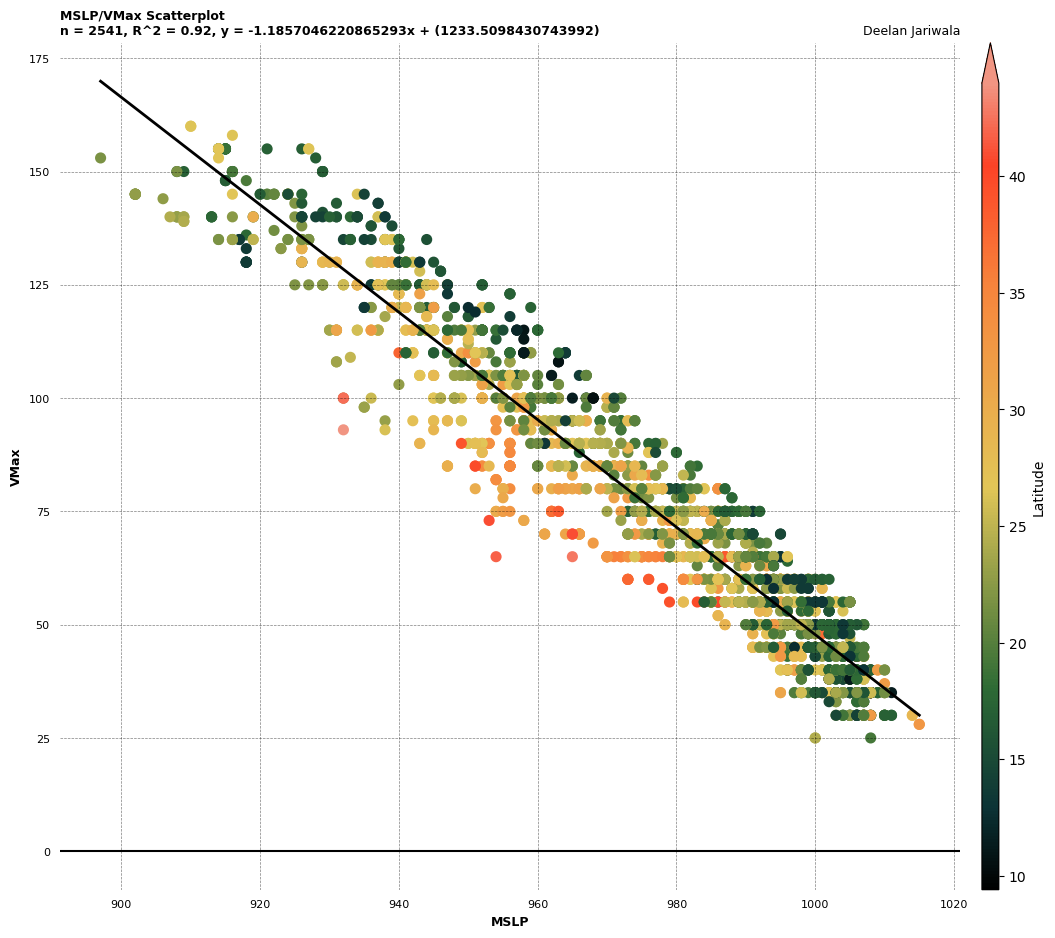

In [15]:
import defaultPlots as dp 

dp.scatter(['MSLP', bPres], ['VMax', bWind], vline = False, z = ['Latitude', bLats])

In [17]:
allData = []
for x in range(len(bPres)):
    year = bTimes[x].year
    month = bTimes[x].month
    day = bTimes[x].day
    time = str(bTimes[x].hour).zfill(2) + str(bTimes[x].minute).zfill(2)
    loc = (bLats[x], bLons[x])
    print(year, month, day, time, loc)
    try:
        satt = '16'
        data = getData(satt, year, month, day, time, loc)
        print(x, data)
        allData.append(data)
    except:
        satt = '19'
        data = getData(satt, year, month, day, time, loc)
        print(x, data)
        allData.append(data)
print(allData)

2017 6 19 2100 (np.float64(9.4), np.float64(-59.7))
9.4 -59.7
Dimensions = 2
current iteration is: 0
current iteration is: 1
current iteration is: 2
current iteration is: 3
ir_rad_dif: 7.60
ir_grad: 0.76
curr_std: 4.41
eye_score: 3.89
Done.
0 [nan, nan, nan, nan, nan, nan]
2017 6 20 0000 (np.float64(24.0), np.float64(-89.2))
24.0 -89.2
Dimensions = 2
current iteration is: 0
current iteration is: 1
ir_rad_dif: 17.01
ir_grad: 2.27
curr_std: 12.46
eye_score: 1.46
Done.
New Coordinates:  23.96370300000018 -89.2002999999991
23.96370300000018 -89.2002999999991
1 [nan, nan, nan, nan, nan, nan]
2017 6 20 1800 (np.float64(25.6), np.float64(-90.6))
25.6 -90.6
Dimensions = 2
current iteration is: 0
current iteration is: 1
ir_rad_dif: 3.92
ir_grad: 0.09
curr_std: 1.52
eye_score: 3.84
Done.
2 [nan, nan, nan, nan, nan, nan]
2017 6 21 0000 (np.float64(26.2), np.float64(-90.9))
26.2 -90.9
Dimensions = 2
current iteration is: 0
current iteration is: 1
current iteration is: 2
current iteration is: 3
cur

In [18]:
print(allData)

[[nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan], [np.int64(171), np.float64(9.76097165293079), np.int64(27), np.float64(1.1399691473690043), np.float64(-38.28846662863961), np.int64(129)], [np.int64(171), np.float64(9.76097165293079), np.int64(27), np.float64(1.1399691473690043), np.float64(-38.28846662863961), np.int64(129)], [nan, nan, nan, nan, nan, nan], [np.int64(28), np.float64(10.199692538813771), np.int64(16), np.float64(-0.7596491273625415), np.float64(-29.057784375525983), np.int64(33)], [nan, nan, nan, nan, nan, nan], [

In [19]:
with open(r"C:\Users\deela\Downloads\ESTIMATES.txt", 'w') as file:
    for x in range(len(allData)):
        file.write(str(allData[x])[1:-1] + "\n")
np.savetxt(r"C:\Users\deela\Downloads\ESTIMATES.txt", allData, delimiter=',')


In [20]:
test = np.array(allData)
print(test.shape)

(2541, 6)


2541 (2541,)
[[0.43865805]]
-84.15084696662186 21.378658513590683


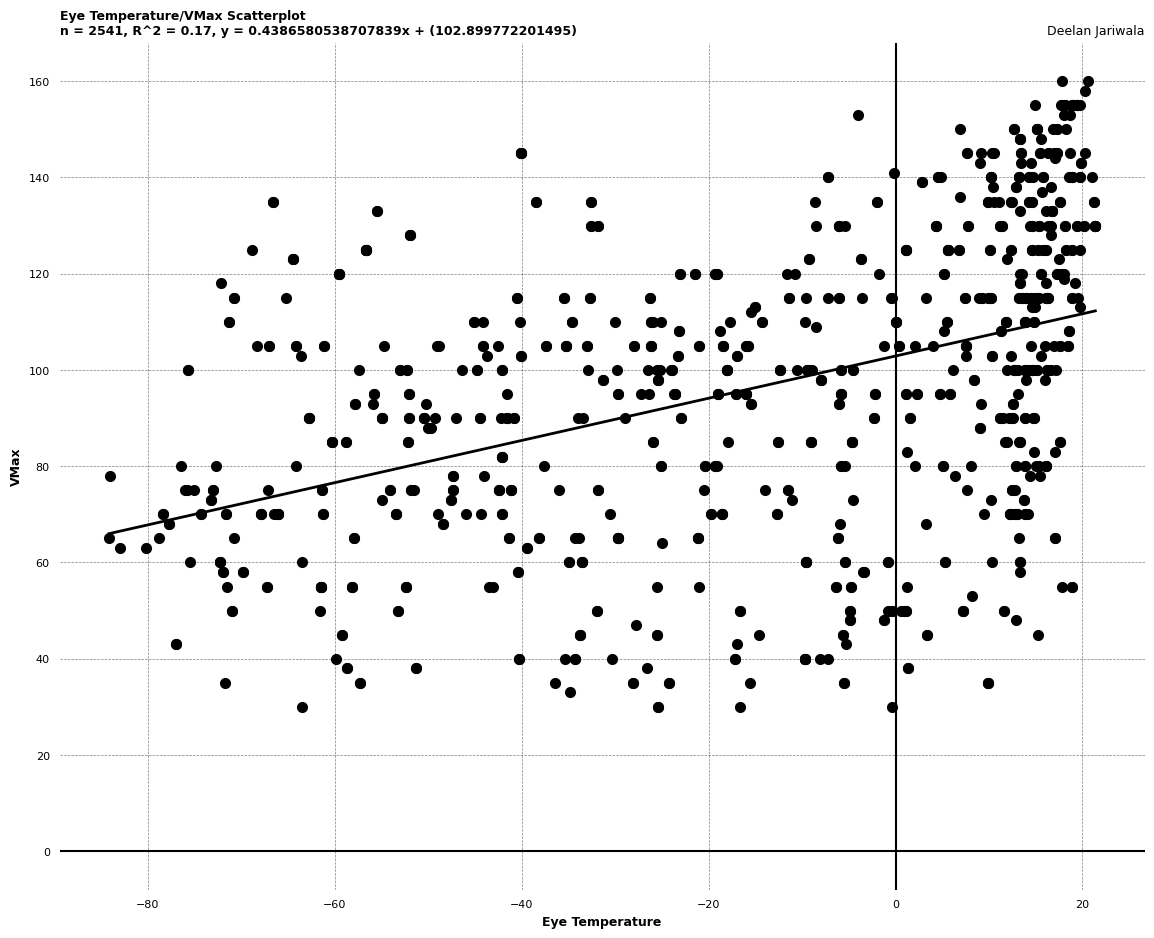

In [21]:
dp.scatter(['Eye Temperature', test[:, 3]], ['VMax', bWind])

2541 (2541,)
[[-1.07620848]]
-84.20543095719646 -6.368362681415195


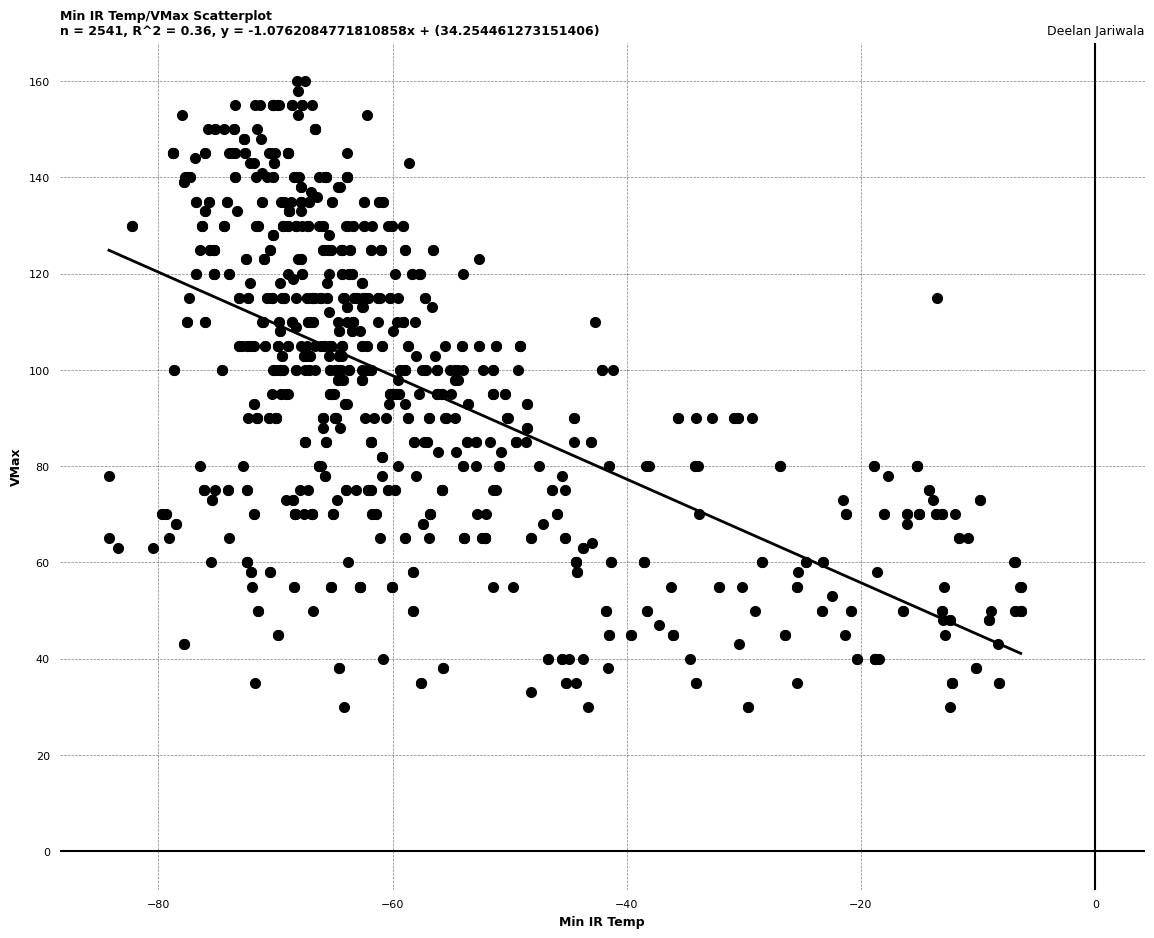

In [22]:
dp.scatter(['Min IR Temp', test[:, 4]], ['VMax', bWind])

2541 (2541,)
[[0.15694359]]
2.0 240.0


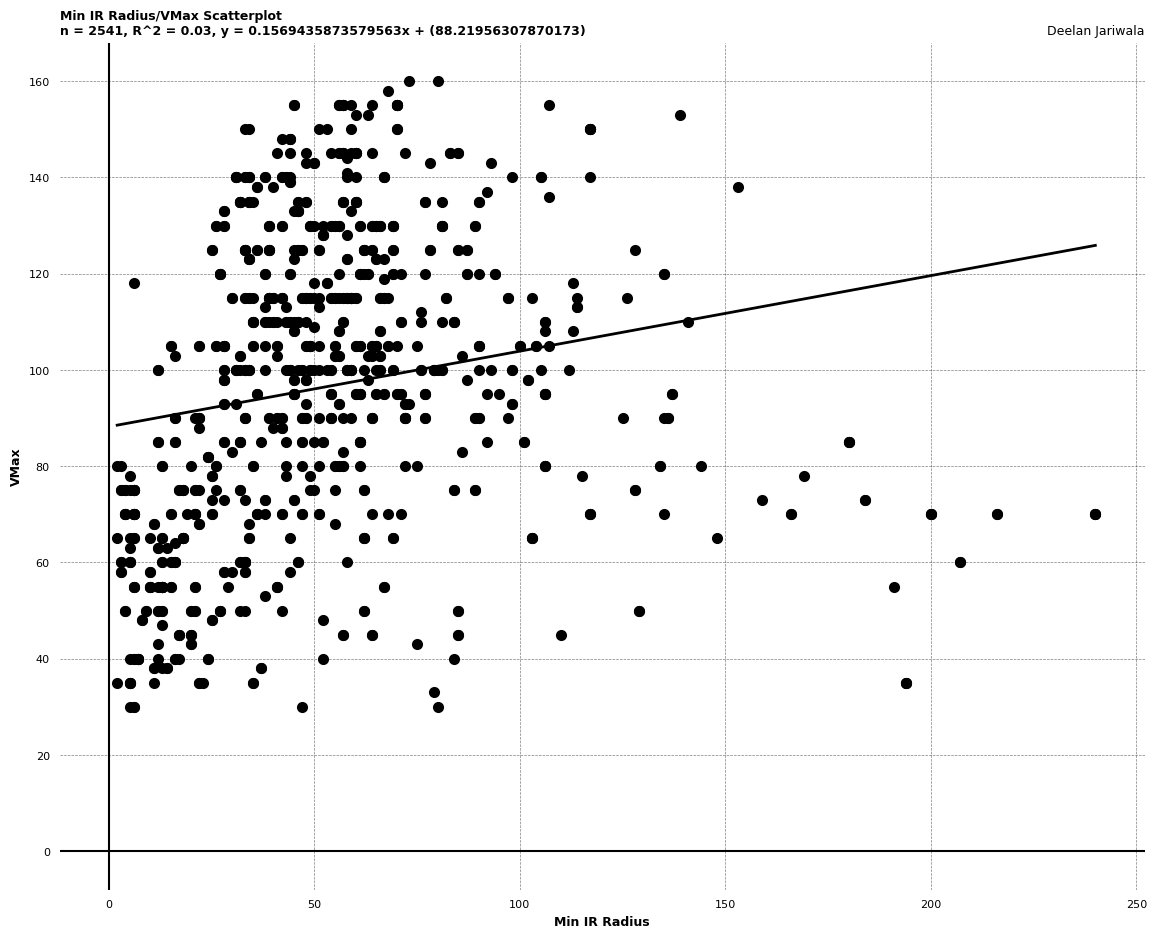

In [23]:
dp.scatter(['Min IR Radius', test[:, 5]], ['VMax', bWind])

2541 (2541,)
[[0.24618398]]
2.0 381.0


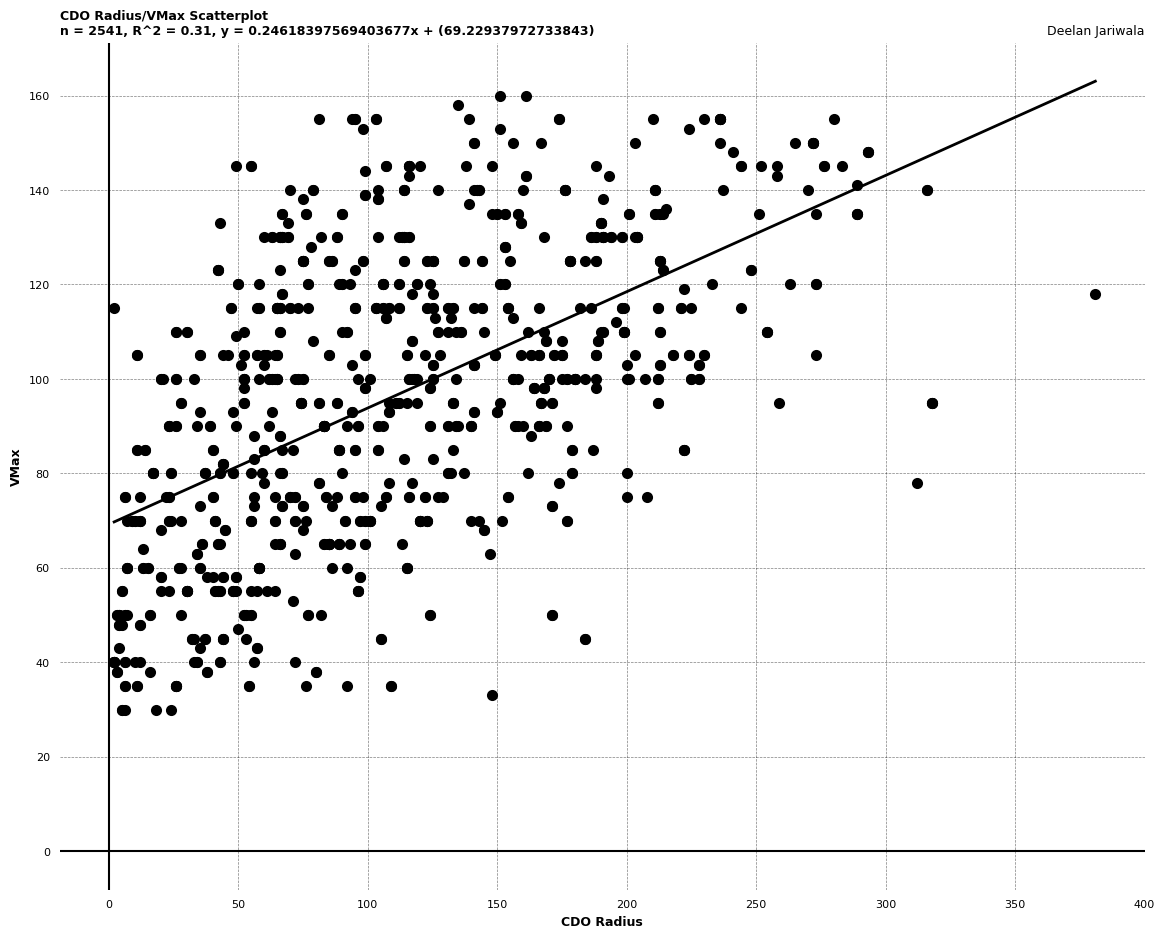

In [24]:
dp.scatter(['CDO Radius', test[:, 0]], ['VMax', bWind])

2541 (2541,)
[[-5.3712914]]
0.9797869308763224 19.364537074675972


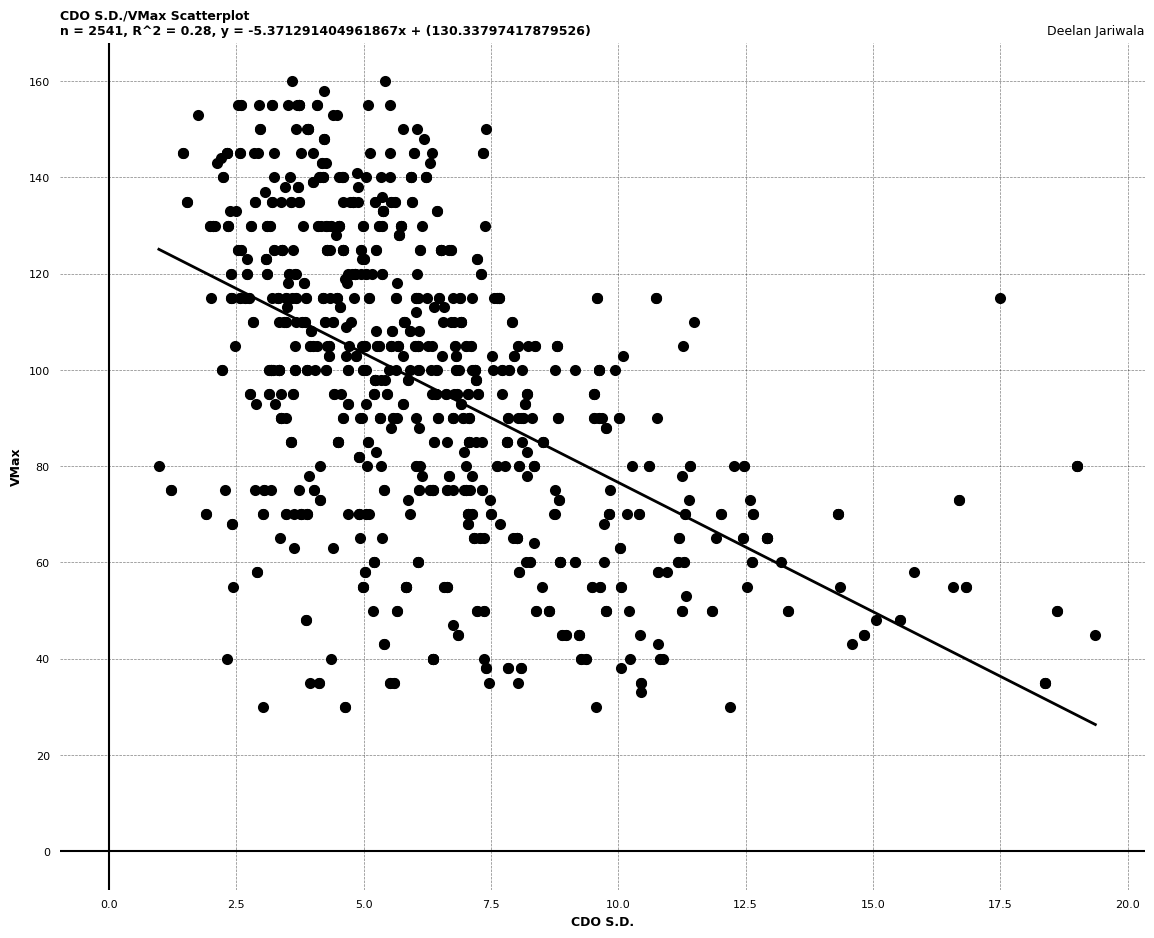

In [25]:
dp.scatter(['CDO S.D.', test[:, 1]], ['VMax', bWind])

2541 (2541,)
[[-0.12679389]]
0.0 198.0


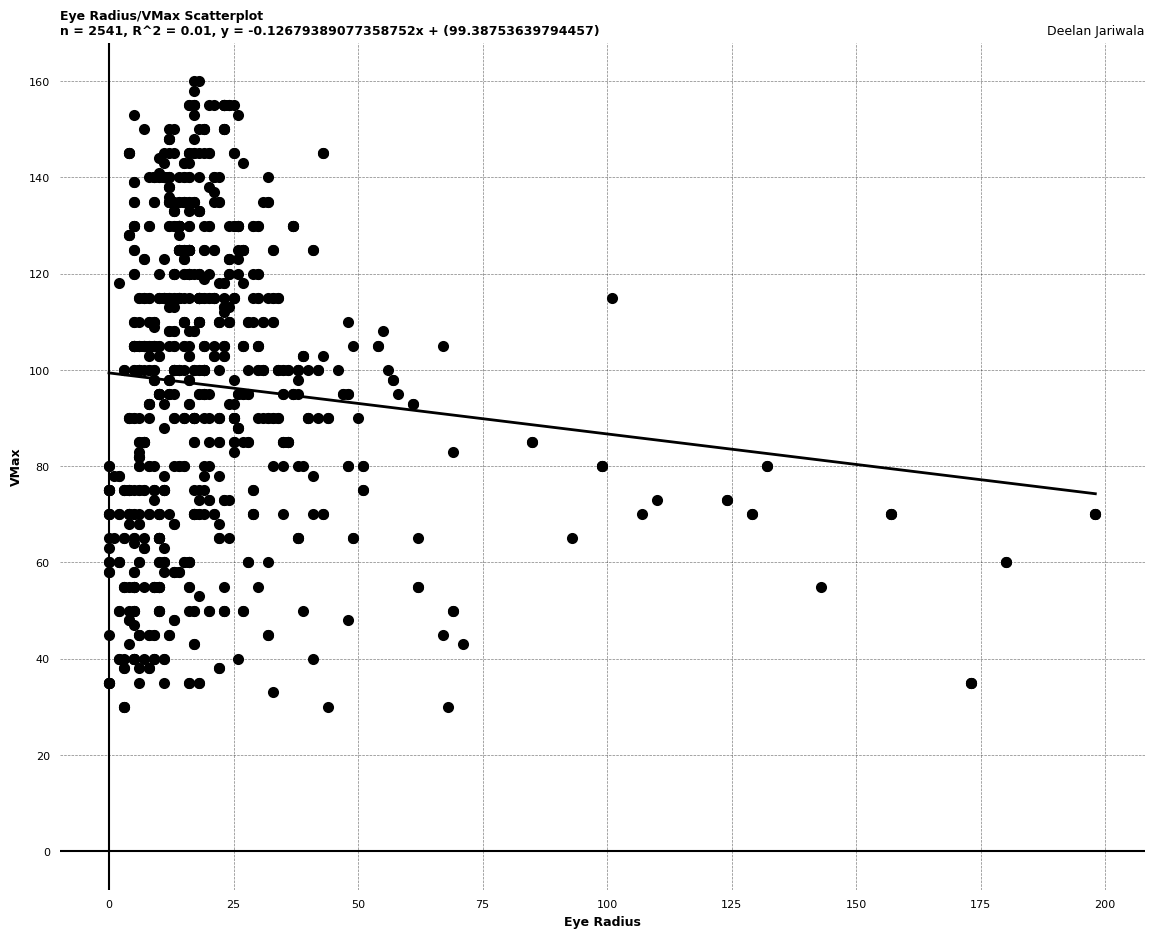

In [26]:
dp.scatter(['Eye Radius', test[:, 2]], ['VMax', bWind])

In [112]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import scipy 
import requests
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def regression(input, output, RF = True, GB = False, poly = False): 
    print(input.shape, output.shape)    
    trainIn = input[:700]
    trainOut = output[:700]
    testIn = input[700:]
    testOut = output[700:]

    if RF == True:
        regr = RandomForestRegressor(n_estimators=200, n_jobs=-1)#, max_features = 0.75, max_depth = 25)
        regr.fit(trainIn, trainOut) 
        predictTest = regr.predict(testIn)
    elif GB == True:
        regr = XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=10,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='reg:squarederror',
            random_state=42
        )
        regr.fit(trainIn, trainOut)
        predictTest = regr.predict(testIn)
    elif poly == True:
        regr = make_pipeline(
            PolynomialFeatures(degree=2, include_bias=False),
            LinearRegression()
        )
        regr.fit(trainIn, trainOut)
        predictTest = regr.predict(testIn)
    else:
        regr = linear_model.LinearRegression()
        regr.fit(trainIn, trainOut)
        predictTest = regr.predict(testIn)

    try:
        importance = regr.feature_importances_
    except:
        try:
            coef = np.abs(regr.coef_ * np.nanstd(input, axis = 0))
            importance = coef / np.sum(coef)
        except:
            importance = None
            pass 

    corr, sig = scipy.stats.pearsonr(predictTest, testOut)
    error2 = np.sqrt(np.mean((predictTest - testOut)**2))
    error = np.mean(np.abs(predictTest - testOut))
    dp.scatter(['Predicted VMax (kt)', predictTest], ['VMax (kt)', testOut])#, hline = False, vline = False)

    print(str(error) + f"kt MAE\n{str(error2)}kt RSME\nR^2: {corr**2}")

    return regr, predictTest, importance, testIn, testOut

(7, 2541)
0 CDO Radius 2541
1 CDO S.D. 2541
2 Eye Radius 2541
3 Eye Temperature 2541
4 Minimum IR Temperature 2541
5 Minimum IR Radius 2541
6 Latitude 2541
(921, 7) (921,)
221 (221,)
[[0.94650383]]
35.71372434653991 140.93969991980896


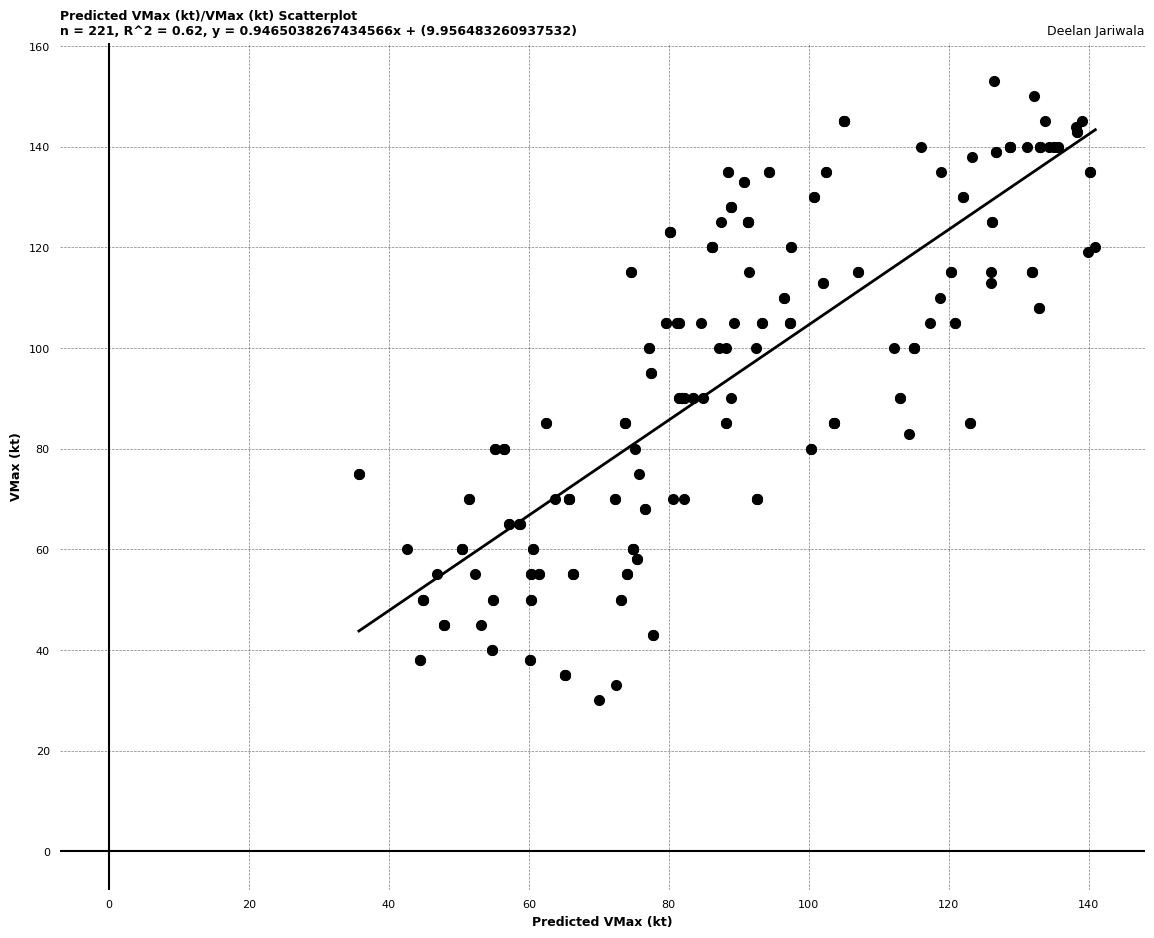

17.120318638796007kt MAE
20.857761444725977kt RSME
R^2: 0.6179956999943274
Feature:                          CDO Radius, Importance: 0.08590136374066545
Feature:                            CDO S.D., Importance: 0.07260095811924995
Feature:                          Eye Radius, Importance: 0.06240334760103587
Feature:                     Eye Temperature, Importance: 0.3623272974815083
Feature:              Minimum IR Temperature, Importance: 0.3657615095807425
Feature:                   Minimum IR Radius, Importance: 0.005766069240412088
Feature:                            Latitude, Importance: 0.04523945423638593




In [121]:
xNames = ['CDO Radius', 'CDO S.D.', 'Eye Radius', 'Eye Temperature', 'Minimum IR Temperature', 'Minimum IR Radius', 'Latitude']
x = test.T
x = np.vstack((x, bLats))
print(x.shape)
y = bWind

for i, (name, arr) in enumerate(zip(xNames, x)):
    print(i, name, len(arr))

x = [np.asarray(a, dtype=float) for a in x]
# mask = x[6] < 20         
# x = [a[mask] for a in x]
# y = y[mask]

y = np.where(y == 9999, np.nan, y)

# Start with a mask of all True
mask = ~np.isnan(y) & ~np.isinf(y)

# Update the mask based on each predictor
for i in range(len(x)):
    mask = mask & ~np.isnan(x[i]) & ~np.isinf(x[i])

# Apply the final mask to each predictor
for i in range(len(x)):
    x[i] = x[i][mask]
    # x[i] = norm(x[i])

# Apply the mask to the target
y = y[mask]

# Stack predictors into 2D array and regress
x = np.column_stack(x)

regr, predictTest, importance, testIn, testOut= regression(x, y, RF = False, GB = False, poly = False)

feat = dict(zip(xNames, importance))
# Print one key-value pair at a time
for key, value in feat.items():
    print(f"Feature: {key:>35}, Importance: {value}")
print('\n')
# for x in range(len(storm_name)):
#     print(storm_name[x], y[x], predictTest[x])

In [122]:
print(regr.coef_, regr.intercept_)

[ 0.06215536 -1.21211881  0.12895142  0.62636831 -1.07037327  0.00791547
 -0.40603932] 49.25812600686074


In [120]:
stormParams = [np.int64(119), np.float64(1.8733703840887936), np.int64(14), np.float64(21.600946535214856), np.float64(-72.28725888691147), np.int64(46), 1011, 23.1]

a = regr.predict([stormParams])
print(a, 0.922 * a + 11.55)

[138.58236723] [139.32294258]
